<a href="https://colab.research.google.com/github/Ceciliapjr0412/COM257_jiarongPei_a4/blob/main/projectGroup5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import zipfile
import os

# 解压上传的 zip 文件
zip_path = "/content/FaceMaskData.zip"  # 上传后的路径（默认在 /content 下）
extract_dir = "/content/FaceMaskData"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

Epoch 1 - Loss: 0.4478
Epoch 2 - Loss: 0.4167
Epoch 3 - Loss: 0.4003
Epoch 4 - Loss: 0.4148
Epoch 5 - Loss: 0.3873

Classification Report:

              precision    recall  f1-score   support

   with_mask       0.85      1.00      0.92       140
without_mask       0.00      0.00      0.00        24

    accuracy                           0.85       164
   macro avg       0.43      0.50      0.46       164
weighted avg       0.73      0.85      0.79       164



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


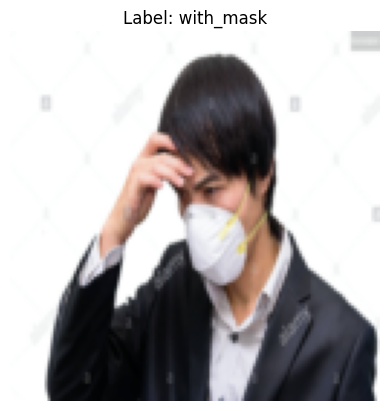

In [12]:
# COMP 263 Term Project - CNN for Face Mask Detection
# Dataset: https://www.kaggle.com/andrewmvd/face-mask-detection

# =============================
# 1. Setup and Imports
# =============================
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets, models
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# =============================
# 2. Define Paths and Transforms
# =============================
data_dir = "/content/FaceMaskData/FaceMaskData/"

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'Train'), transform=transform)
val_dataset = datasets.ImageFolder(os.path.join(data_dir, 'Validation'), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# =============================
# 3. Define CNN Model
# =============================
class MaskCNN(nn.Module):
    def __init__(self):
        super(MaskCNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 2)
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

# =============================
# 4. Train the Model
# =============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MaskCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(5):
    model.train()
    running_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1} - Loss: {running_loss/len(train_loader):.4f}")

# =============================
# 5. Evaluate Model
# =============================
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(preds.cpu().numpy())

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=train_dataset.classes))

# =============================
# 6. Sample Visualization
# =============================
import random
inputs, classes = next(iter(val_loader))
idx = random.randint(0, len(inputs) - 1)
img = inputs[idx].permute(1, 2, 0) * 0.5 + 0.5
plt.imshow(img)
plt.title(f"Label: {train_dataset.classes[classes[idx]]}")
plt.axis("off")
plt.show()


Epoch 1, Loss: 0.0836
Epoch 2, Loss: 0.0587
Epoch 3, Loss: 0.0275
Epoch 4, Loss: 0.0189
Epoch 5, Loss: 0.0163


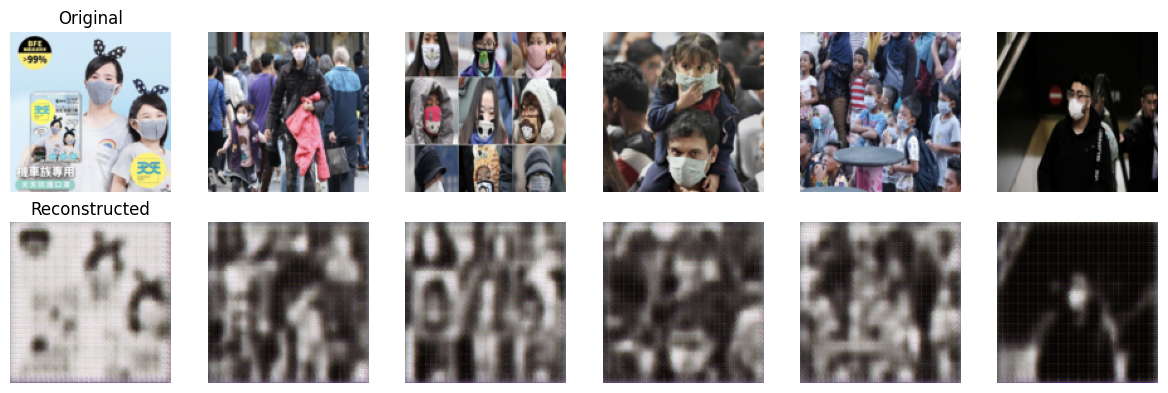

In [14]:
# Unsupervised Learning: Autoencoder for Feature Extraction on Face Mask Images

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import os

# =============================
# 1. Load Data (same as CNN but unlabeled)
# =============================
data_dir = "/content/FaceMaskData/FaceMaskData/"

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

train_dataset = datasets.ImageFolder(os.path.join(data_dir, "Train"), transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# =============================
# 2. Define Autoencoder
# =============================
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1),  # 64x64
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # 32x32
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), # 16x16
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2, output_padding=1, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=1, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 3, stride=2, output_padding=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# =============================
# 3. Train Autoencoder
# =============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
autoencoder = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)

for epoch in range(5):
    autoencoder.train()
    running_loss = 0
    for imgs, _ in train_loader:
        imgs = imgs.to(device)
        optimizer.zero_grad()
        outputs = autoencoder(imgs)
        loss = criterion(outputs, imgs)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}")

# =============================
# 4. Visualize Reconstruction
# =============================
autoencoder.eval()
with torch.no_grad():
    sample, _ = next(iter(train_loader))
    sample = sample.to(device)
    output = autoencoder(sample)

    # Show original vs reconstructed
    fig, axs = plt.subplots(2, 6, figsize=(12, 4))
    for i in range(6):
        axs[0, i].imshow(sample[i].permute(1, 2, 0).cpu().numpy())
        axs[0, i].axis("off")
        axs[1, i].imshow(output[i].permute(1, 2, 0).cpu().numpy())
        axs[1, i].axis("off")
    axs[0, 0].set_title("Original")
    axs[1, 0].set_title("Reconstructed")
    plt.tight_layout()
    plt.show()

In [15]:


import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
import time
import os

# =============================
# 1. Data Loading
# =============================

data_dir = "/content/FaceMaskData/FaceMaskData/"
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_ds = datasets.ImageFolder(os.path.join(data_dir, 'Train'), transform=transform)
val_ds = datasets.ImageFolder(os.path.join(data_dir, 'Validation'), transform=transform)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)

# =============================
# 2. Choose SOTA model (MobileNetV2 or ResNet50)
# =============================
def get_model(model_name='mobilenetv2', num_classes=2):
    if model_name == 'mobilenetv2':
        model = models.mobilenet_v2(pretrained=True)
        model.classifier[1] = nn.Linear(model.last_channel, num_classes)
    elif model_name == 'resnet50':
        model = models.resnet50(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    else:
        raise ValueError("Invalid model name")
    return model

# =============================
# 3. Training Function
# =============================
def train_model(model, criterion, optimizer, num_epochs=3):
    model.to(device)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1} - Loss: {running_loss/len(train_loader):.4f}")
    return model

# =============================
# 4. Evaluation Function
# =============================
def evaluate_model(model):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.numpy())
            y_pred.extend(preds.cpu().numpy())
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=train_ds.classes))

# =============================
# 5. Run Training + Evaluation
# =============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# MobileNetV2
print("\n=== MobileNetV2 ===")
mnet = get_model("mobilenetv2")
mnet = train_model(mnet, nn.CrossEntropyLoss(), optim.Adam(mnet.parameters(), lr=0.0003))
evaluate_model(mnet)

# ResNet50
print("\n=== ResNet50 ===")
resnet = get_model("resnet50")
resnet = train_model(resnet, nn.CrossEntropyLoss(), optim.Adam(resnet.parameters(), lr=0.0003))
evaluate_model(resnet)



=== MobileNetV2 ===


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 46.3MB/s]


Epoch 1 - Loss: 0.3432
Epoch 2 - Loss: 0.1100
Epoch 3 - Loss: 0.0540

Classification Report:
              precision    recall  f1-score   support

   with_mask       0.90      0.97      0.93       140
without_mask       0.69      0.38      0.49        24

    accuracy                           0.88       164
   macro avg       0.80      0.67      0.71       164
weighted avg       0.87      0.88      0.87       164


=== ResNet50 ===


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 102MB/s]


Epoch 1 - Loss: 0.3246
Epoch 2 - Loss: 0.1654
Epoch 3 - Loss: 0.0726

Classification Report:
              precision    recall  f1-score   support

   with_mask       0.90      1.00      0.95       140
without_mask       1.00      0.38      0.55        24

    accuracy                           0.91       164
   macro avg       0.95      0.69      0.75       164
weighted avg       0.92      0.91      0.89       164

